# GAN
- 생성자: 무작위 텐서로부터 여러 가지 형태의 가짜 이미지를 생성해냄
    - 학습이 진행되면서 생성자는 판별자를 속이려고 점점 더 정밀한 가짜 이미지를 생성
- 판별자: 진짜 이미지와 가짜 이미지를 구분함
    - 학습 데이터에서 가져온 진짜 이미지와 생성자가 만든 가짜 이미지를 점점 더 잘 구별하게 됨 

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 하이퍼파라미터
EPOCHS = 5 # 원래 500 이지만 시간상 5 로 설정
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

생성자는 64 차원의 랜덤한 텐서를 입력받아 이에 Linear 와 활성화 함수 (ReLU, Tanh) 연산을 실행합니다. 생성자의 결과값은 784 차원, 즉 Fashion MNIST 속의 이미지와 같은 차원의 텐서입니다

In [4]:
# 생성자 (Generator)
G = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh()) # 결과값을 -1 과 1 사이로 압축함

무작위 텐서를 입력하는 이유는 생성자가 실제 데이터의 '분포'를 배우는 것이기 때문임

판별자는 784 차원의 텐서를 입력받습니다. 판별자 역시 입력된 데이터에 Linear 와 활성화 함수를 실행시키지만, 생성자와 달리 판별자의 결과값은 입력받은 텐서가 진짜인지 구분하는 예측값임

In [5]:
# 판별자 (Discriminator)
D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

Leaky ReLU 는 양의 기울기만 전달하는 ReLU 와 다르게 약간의 음의 기울기도 다음 층에 전달하는 역할을 함. 이렇게 하면 판별자에서 계산된 기울기가 0 이 아니라 약한 음수로 전환되며 생성자에게 더 강하게 전달됨. GAN 에서 생성자가 학습하려면 판별자로부터 기울기를 효과적으로 전달받아야 하므로 중요함

In [6]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

#### 학습

In [7]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
         # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차를 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))  

Epoch [0/5], d_loss: 0.0833, g_loss: 4.6257, D(x): 0.97, D(G(z)): 0.04
Epoch [1/5], d_loss: 0.2373, g_loss: 4.5115, D(x): 0.92, D(G(z)): 0.02
Epoch [2/5], d_loss: 0.1547, g_loss: 7.3001, D(x): 0.95, D(G(z)): 0.00
Epoch [3/5], d_loss: 0.0512, g_loss: 6.4726, D(x): 0.99, D(G(z)): 0.02
Epoch [4/5], d_loss: 0.0623, g_loss: 6.5196, D(x): 0.97, D(G(z)): 0.01


생성자보다는 판별자의 학습이 빠름. 그래서 학습이 덜 됐을 땐 판별자가 높은 정확도로 진짜와 가짜 이미지를 분류하는 것을 볼 수 있음. 하지만 학습이 진행될수록 생성자가 진짜 같은 가짜 이미지를 만들어내는 법을 익히며 판별자의 정확도가 50% 근처로 내려감. 판별자의 정확도가 50% 근처라는 것은 진짜와 가짜를 구별하지 못한다는 뜻이고 이 때 생성자는 진짜 이미지와 비슷한 그럴듯한 이미지를 만들 수 있게 됨

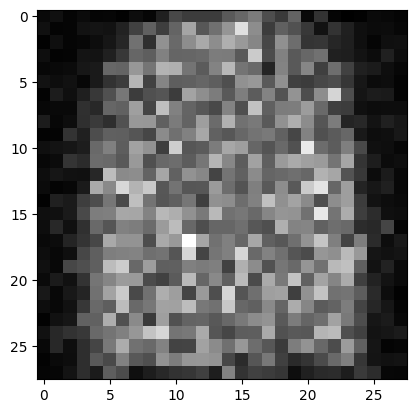

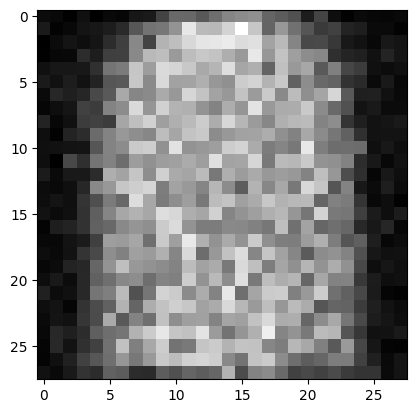

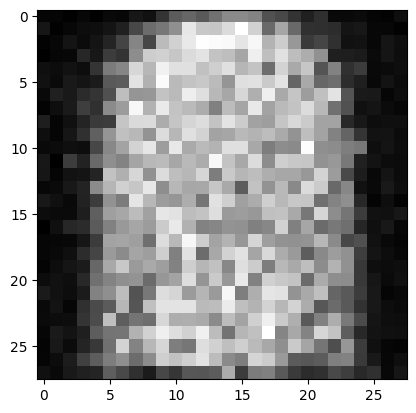

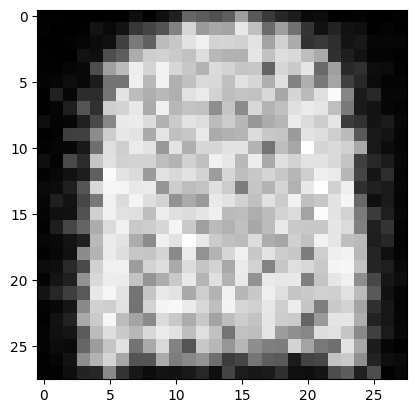

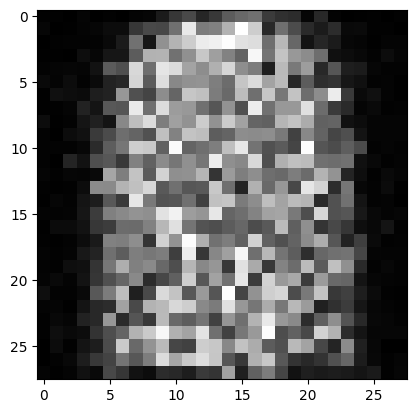

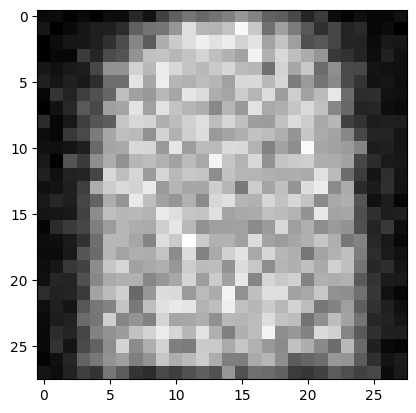

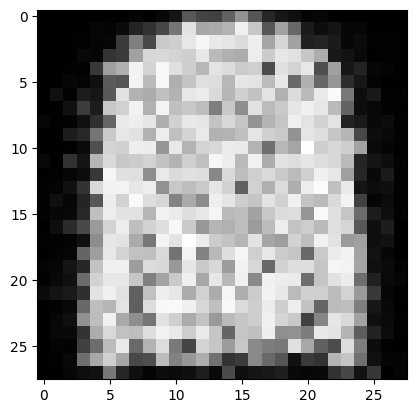

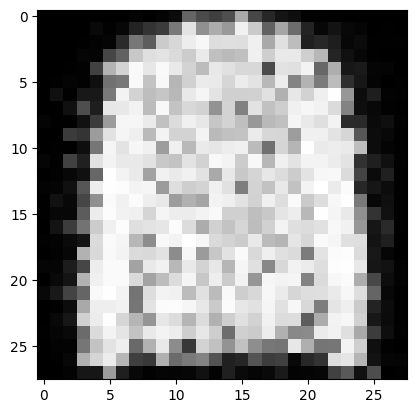

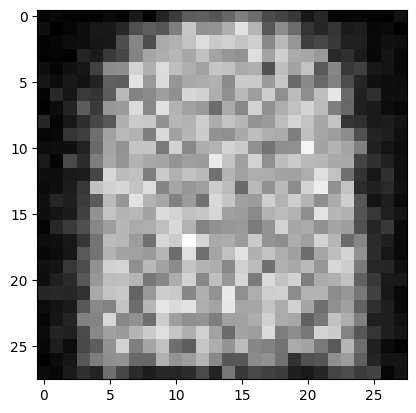

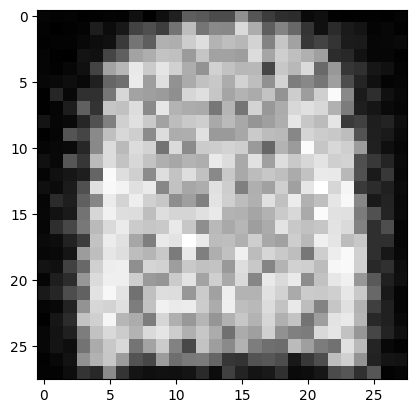

In [8]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()

# Conditional GAN
위 GAN 모델의 코드는 '여러 종류의 패션 아이템 중 무엇을 생성해라'라고 지시하는 로직이 없음. 무작위 벡터를 받아 무작위로 패션 아이템을 출력. 따라서 사용자가 원하는 패션 아이템을 생성하는 능력이 없음. CGAN 은 출력할 아이템의 종류를 사용자로부터 입력받아 그에 해당하는 이미지를 생성하는 모델이다.

In [23]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# 하이퍼파라미터
EPOCHS = 5 # 원래 300 이지만 시간상 5 으로 설정
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [25]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

In [26]:
# Generator 
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256), # 10 개의 label 정보를 받기 때문에 100 + 10
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [27]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [28]:
# 모델 인스턴스를 만들고 모델의 가중치를 지정한 장치로 보내기
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# 이진 교차 엔트로피 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr =0.0002)
g_optimizer = optim.Adam(G.parameters(), lr =0.0002)

In [29]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
         # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch,
                  EPOCHS,
                  d_loss.item(),
                  g_loss.item(),
                  real_score.mean().item(),
                  fake_score.mean().item()))

이폭 [0/5] d_loss:0.4452 g_loss: 3.2313 D(x):0.91 D(G(z)):0.22
이폭 [1/5] d_loss:0.9335 g_loss: 3.4598 D(x):0.86 D(G(z)):0.30
이폭 [2/5] d_loss:0.4240 g_loss: 3.6983 D(x):0.92 D(G(z)):0.17
이폭 [3/5] d_loss:0.8757 g_loss: 2.5628 D(x):0.72 D(G(z)):0.15
이폭 [4/5] d_loss:0.3981 g_loss: 3.1075 D(x):0.86 D(G(z)):0.10


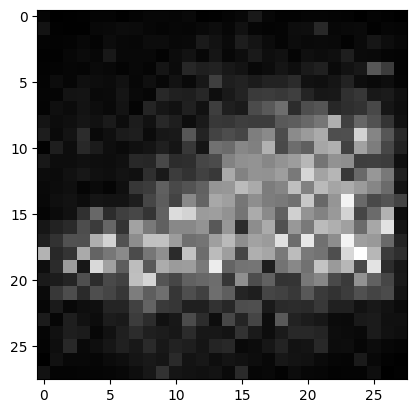

In [ ]:
# 만들고 싶은 아이템 생성하고 시각화하기
item_number = 9 # 아이템 번호
z = torch.randn(1, 100).to(DEVICE) # 배치 크기 1
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)
sample_images = G(z, g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()
                               [0],(28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()